In [1]:
import pymolpro as pmp
import numpy as np
import math
import os

In [2]:

scaleddb=pmp.database.Database()

for xyz in os.listdir('scaled'): 
    if xyz.endswith('.xyz'):
        f=open(f'/home/stuart/Hydrocarbons/scaled/{xyz}')
        scaleddb.add_molecule(name=xyz[:-4], geometry=f.read())

db=pmp.database.run(scaleddb,preamble='symmetry, nosym',method='locali,pipek;ccsd',basis='cc-pVTZ', parallel=3, postamble='put,xml')

In [31]:
def dictbuilder(orbital,v):
    oid,noid=orbital.ID,f'-{orbital.ID}'
    #build the grid using n points and evaluate
    points=orbital.grid(n)
    values=orbital.evaluate(points,values=True)
    moments=orbital.second_moment_eigenvalues
    
    moments=np.append(moments,float(v.xpath("//orbitals/orbital[@ID='"+orbital.ID+"']/@energy")[0]))
    moments=np.append(moments,float(orbital.kinetic_energy))
    nmoments=np.append(moments,-1)
    moments=np.append(moments,1)
    
    orbiaddfeats.update({oid:moments})
    orbiaddfeats.update({f'-{oid}':nmoments})
    
    #values=values**2
    #puts them into the dictionaries
    orbitaldt.update({oid:values})
    orbitaldt.update({f'-{oid}':values})
    #probably unnecessary, but works
    if orbital.ID not in griddt:
        griddt[orbital.ID] = {}
        griddt[f'-{orbital.ID}']={}
    #xyz is arbitrary, just to keep consistency and easy to call later
    griddt[oid].update({i:{
        'x':float(points[i][0]),
        'y':float(points[i][1]),
        'z':float(points[i][2])
        }for i in range(len(points))})
    griddt[f'-{oid}'].update({i:{
        'x':float(points[i][0]),
        'y':float(points[i][1]),
        'z':float(points[i][2])
        }for i in range(len(points))})


def chkorbid(o1,o2):
    if o1.startswith('-'):
        chko1=o1[1:]
    else:
        chko1=o1
    if o2.startswith('-'):
        chko2=o2[1:]
    else:
        chko2=o2
    if chko1==chko2:
        return True
    else: 
        return False

def checkspin(o1,o2):
    if o1.startswith('-'):
        spin1=-1
    else:
        spin1=1
    if o2.startswith('-'):
        spin2=-1
    else:
        spin2=1
    return spin1*spin2

def centdist(o1,o2):
    o1x,o1y,o1z = centdt[o1][0], centdt[o1][1],centdt[o1][2]
    o2x,o2y,o2z = centdt[o2][0], centdt[o2][1],centdt[o2][2]
    r=math.sqrt((o1x-o2x)**2+(o1y-o2y)**2+(o1z-o2z)**2)
    if r==0:
        return 0
    else:
        return np.array(1/r**2)

def same_noselfassemble(oid1,oid2,pairdict):
    orbi1denslist_same.append(orbitaldt[oid1])
    orbi1otherlist_same.append(orbiaddfeats[oid1])
    orbi2denslist_same.append(orbitaldt[oid2])
    orbi2otherlist_same.append(orbiaddfeats[oid2])
    distancelist_same.append(distances(oid1,oid2))
    cdistlist_same.append(centdist(oid1,oid2))
    noselflabellist_same.append(float(pairdict['energy']))

def opposite_noselfassemble(oid1,oid2,pairdict):
    orbi1denslist_opposite.append(orbitaldt[oid1])
    orbi1otherlist_opposite.append(orbiaddfeats[oid1])
    orbi2denslist_opposite.append(orbitaldt[oid2])
    orbi2otherlist_opposite.append(orbiaddfeats[oid2])
    distancelist_opposite.append(distances(oid1,oid2))
    cdistlist_opposite.append(centdist(oid1,oid2))
    noselflabellist_opposite.append(float(pairdict['energy']))


def distances(o1,o2):
    #big_arr=np.empty((0,n**3))
    big_list=[]
    for i in range(len(griddt[o1])):
        tmp_list=[]
        for j in range(len(griddt[o2])):
            #find the distance
            o1x,o1y,o1z = griddt[o1][i]['x'], griddt[o1][i]['y'],griddt[o1][i]['z']
            o2x,o2y,o2z = griddt[o2][j]['x'], griddt[o2][j]['y'],griddt[o2][j]['z']
            r=math.sqrt((o1x-o2x)**2+(o1y-o2y)**2+(o1z-o2z)**2)
            #correlation energy should scale like r^-6 so take the reciprocal, going to lead to problems at 0 so take an error function
            if r==0:
                w=1
            else:   
                w=(1/r)
            tmp_list.append(float(w))
        #tmp_arr=np.array(tmp_list)
        #tmp_arr.reshape((1,len(tmp_list)))
        #big_arr=np.vstack((big_arr,tmp_arr))
        big_list = big_list + tmp_list
    #big_arr=np.vstack((big_arr, orbitaldt[o1], orbitaldt[o2]))
    return np.array(big_list)


In [32]:
#settings
#number of grid points to use (will increase input features n**3 and compute time the same way so dont go too high
n=4

#alpha in the error function

a=1

#the arrays are stored in a list until the end of the calculations to then be np.stack()
selffeaturelist=[]
selfaddfeatslist=[]
selflabellist=[]

sameselflabellist=[]
oppnoselflabellist=[]

samecentlist=[]
oppcentlist=[]

orbi1denslist_same = []
orbi1denslist_opposite = []

orbi1otherlist_same = []
orbi1otherlist_opposite = []

orbi2denslist_same = []
orbi2denslist_opposite = []

orbi2otherlist_same = []
orbi2otherlist_opposite = []

distancelist_same = []
distancelist_opposite = []

cdistlist_same = []
cdistlist_opposite = []

noselflabellist_same = []
noselflabellist_opposite = []


for k,v in db.projects.items():
    #used to store the density key = orbital ID, values=orbital.evaluate
    orbitaldt={}
    #stores the XYZ coordinates for the grid to later be used for the distances. key= orbital id, values= 'x','y','z'
    griddt={}
    #additional features, second moment eigenvalues, orbital energy, kinetic energy.
    orbiaddfeats={}

    centdt={}
    for orbital in v.orbitals():
        #stores the evaluated orbital and grid coordinates in different dictionaries
        dictbuilder(orbital,v)
        centdt.update({orbital.ID:orbital.centroid})
        centdt.update({f'-{orbital.ID}':orbital.centroid})
    
    for pair in v.xpath("//pair"):
        temp=pmp.element_to_dict(pair)
        oid1,oid2=temp['orbital1'],temp['orbital2']
        if chkorbid(oid1,oid2)==True:
            selffeaturelist.append(np.array(orbitaldt[oid1]))
            selfaddfeatslist.append(np.array(orbiaddfeats[oid1]))
            selflabellist.append(float(temp['energy']))
        else:
            if checkspin(oid1,oid2)==1:
                same_noselfassemble(oid1,oid2,temp)
            else:
                opposite_noselfassemble(oid1,oid2,temp)
           



split=int(0.8*len(selffeaturelist))

trainselffeats=np.stack(selffeaturelist[:split])
trainselfaddfeats=np.stack(selfaddfeatslist[:split])
trainselflabels=np.stack(selflabellist[:split])
testfeats=np.stack(selffeaturelist[split:])
testaddfeats=np.stack(selfaddfeatslist[split:])
testselflabels=np.stack(selflabellist[split:])

np.save('data/trainselffeats.npy', trainselffeats)
np.save('data/trainselfaddfeats.npy', trainselfaddfeats)
np.save('data/trainselflabels.npy', trainselflabels)

np.save('data/testfeats.npy', testfeats)
np.save('data/testaddfeats.npy', testaddfeats)
np.save('data/testselflabels.npy', testselflabels)

split=int(0.8*len(noselflabellist_same))

# "Same" labeled data
trainorbital1density_same = np.stack(orbi1denslist_same[:split])
trainorbital1other_same = np.stack(orbi1otherlist_same[:split])
trainorbital2density_same = np.stack(orbi2denslist_same[:split])
trainorbital2other_same = np.stack(orbi2otherlist_same[:split])
traindistance_same = np.stack(distancelist_same[:split])
trainlabels_same = np.stack(noselflabellist_same[:split])

testorbital1density_same = np.stack(orbi1denslist_same[split:])
testorbital1other_same = np.stack(orbi1otherlist_same[split:])
testorbital2density_same = np.stack(orbi2denslist_same[split:])
testorbital2other_same = np.stack(orbi2otherlist_same[split:])
testdistance_same = np.stack(distancelist_same[split:])
testlabels_same = np.stack(noselflabellist_same[split:])

# "Opposite" labeled data

split = int(0.8 * len(noselflabellist_opposite))

trainorbital1density_opposite = np.stack(orbi1denslist_opposite[:split])
trainorbital1other_opposite = np.stack(orbi1otherlist_opposite[:split])
trainorbital2density_opposite = np.stack(orbi2denslist_opposite[:split])
trainorbital2other_opposite = np.stack(orbi2otherlist_opposite[:split])
traindistance_opposite = np.stack(distancelist_opposite[:split])
trainlabels_opposite = np.stack(noselflabellist_opposite[:split])

testorbital1density_opposite = np.stack(orbi1denslist_opposite[split:])
testorbital1other_opposite = np.stack(orbi1otherlist_opposite[split:])
testorbital2density_opposite = np.stack(orbi2denslist_opposite[split:])
testorbital2other_opposite = np.stack(orbi2otherlist_opposite[split:])
testdistance_opposite = np.stack(distancelist_opposite[split:])
testlabels_opposite = np.stack(noselflabellist_opposite[split:])

# Saving "same" labeled training data
np.save('data/trainorbital1density_same.npy', trainorbital1density_same)
np.save('data/trainorbital1other_same.npy', trainorbital1other_same)
np.save('data/trainorbital2density_same.npy', trainorbital2density_same)
np.save('data/trainorbital2other_same.npy', trainorbital2other_same)
np.save('data/traindistance_same.npy', traindistance_same)
np.save('data/trainlabels_same.npy', trainlabels_same)

# Saving "same" labeled test data
np.save('data/testorbital1density_same.npy', testorbital1density_same)
np.save('data/testorbital1other_same.npy', testorbital1other_same)
np.save('data/testorbital2density_same.npy', testorbital2density_same)
np.save('data/testorbital2other_same.npy', testorbital2other_same)
np.save('data/testdistance_same.npy', testdistance_same)
np.save('data/testlabels_same.npy', testlabels_same)

# Saving "opposite" labeled training data
np.save('data/trainorbital1density_opposite.npy', trainorbital1density_opposite)
np.save('data/trainorbital1other_opposite.npy', trainorbital1other_opposite)
np.save('data/trainorbital2density_opposite.npy', trainorbital2density_opposite)
np.save('data/trainorbital2other_opposite.npy', trainorbital2other_opposite)
np.save('data/traindistance_opposite.npy', traindistance_opposite)
np.save('data/trainlabels_opposite.npy', trainlabels_opposite)

# Saving "opposite" labeled test data
np.save('data/testorbital1density_opposite.npy', testorbital1density_opposite)
np.save('data/testorbital1other_opposite.npy', testorbital1other_opposite)
np.save('data/testorbital2density_opposite.npy', testorbital2density_opposite)
np.save('data/testorbital2other_opposite.npy', testorbital2other_opposite)
np.save('data/testdistance_opposite.npy', testdistance_opposite)
np.save('data/testlabels_opposite.npy', testlabels_opposite)


<function matplotlib.pyplot.show(close=None, block=None)>

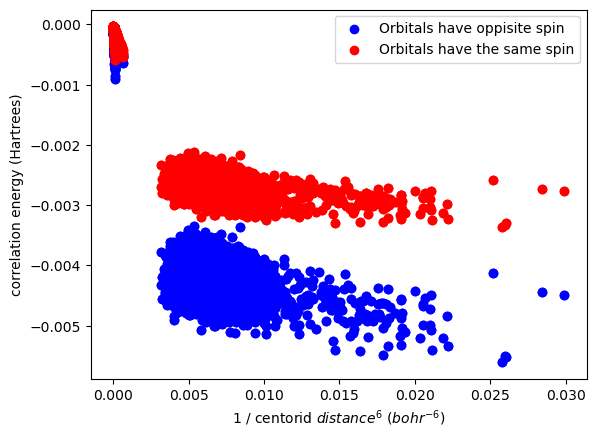

In [8]:
import matplotlib.pyplot as plt

plt.scatter(oppcentlist,oppnoselflabellist,c='blue',label='Orbitals have oppisite spin')
plt.scatter(samecentlist,sameselflabellist,c='red',label='Orbitals have the same spin')
plt.xlabel(r'1 / centorid $distance^{6}$ ($bohr^{-6}$)')
plt.ylabel('correlation energy (Hartrees)')
plt.savefig('reciprocal-6-centroid-distance-correlation-energy.png')
plt.legend()
plt.show

In [48]:
import tensorflow as tf
import keras

split=int(0.8*len(selffeaturelist))

trainselffeats=np.stack(selffeaturelist[:split])
trainselfaddfeats=np.stack(selfaddfeatslist[:split])
trainselflabels=np.stack(selflabellist[:split])
testfeats=np.stack(selffeaturelist[split:])
testaddfeats=np.stack(selfaddfeatslist[split:])
testselflabels=np.stack(selflabellist[split:])



# Define NN1
class NN1(tf.keras.Model):
    def __init__(self):
        super(NN1, self).__init__()
        self.dense1 = tf.keras.layers.Dense(640, activation='softmax')
        self.dense2 = tf.keras.layers.Dense(3)
    
    def call(self, inputs):
        x = self.dense1(inputs)
        return self.dense2(x)

# Define NN2
class NN2(tf.keras.Model):
    def __init__(self):
        super(NN2, self).__init__()
        self.dense1 = tf.keras.layers.Dense(100, activation='relu')
        self.dense2 = tf.keras.layers.Dense(1) 
    
    def call(self, inputs):
        x = self.dense1(inputs)
        return self.dense2(x)

def predict(x1, x2):
    # Forward pass through NN1
    nn1_output = nn1(x1)
    
    # Combine NN1 output with additional features for NN2 input
    nn2_input = tf.concat([nn1_output, x2], axis=1)
    
    # Forward pass through NN2 to get the final prediction
    y_pred = nn2(nn2_input)
    
    return y_pred    

losstracker={}

# Instantiate the models
nn1 = NN1()
nn2 = NN2()

#dynamic learning rate
init_lr=0.01

# Optimizers
optimizer = tf.keras.optimizers.Adam()


# Loss function
loss_fn = tf.keras.losses.Huber()

# Training loop
epochs = 50000
for epoch in range(epochs):
    with tf.GradientTape() as tape:
        
        #dyn_lr=init_lr * 0.9995 ** epoch 
        #optimizer.learning_rate.assign(dyn_lr)
        
        # Forward pass through NN1
        nn1_output = nn1(trainselffeats)
        
        # Combine NN1 output with additional features for NN2 input
        nn2_input = tf.concat([nn1_output, trainselfaddfeats], axis=1)
        
        # Forward pass through NN2
        y_pred = nn2(nn2_input)
        
        # Calculate loss
        loss = loss_fn(trainselflabels, y_pred)
    
    # Compute gradients and apply updates
    gradients = tape.gradient(loss, nn1.trainable_variables + nn2.trainable_variables)
    optimizer.apply_gradients(zip(gradients, nn1.trainable_variables + nn2.trainable_variables))

    if (epoch+1)%10==0:
        predictions=predict(testfeats,testaddfeats)
        testloss=loss_fn(testselflabels, predictions)
        losstracker.update({epoch:math.log10(loss_fn(testselflabels, predictions))})
        if testloss>10**-3:
            optimizer.learning_rate.assign(0.01)
        elif testloss>10**-4:
            optimizer.learning_rate.assign(0.005)
        elif testloss>10**-5:
            optimizer.learning_rate.assign(0.001)
        elif testloss>10**-6:
            optimizer.learning_rate.assign(0.0005)
        elif testloss>10**-7:
            optimizer.learning_rate.assign(0.0001)
        elif testloss>10**-8:
            optimizer.learning_rate.assign(0.000001)
        
    
    
    
    # Print loss
    print(f'Epoch {epoch + 1}, Loss: {loss.numpy()}')
    


Epoch 1, Loss: 0.0036577184218913317
Epoch 2, Loss: 0.0014654346741735935
Epoch 3, Loss: 0.0016589319566264749
Epoch 4, Loss: 0.002299394691362977
Epoch 5, Loss: 0.002168014645576477
Epoch 6, Loss: 0.001626166165806353
Epoch 7, Loss: 0.0012074691476300359
Epoch 8, Loss: 0.0011497403029352427
Epoch 9, Loss: 0.0013379137963056564
Epoch 10, Loss: 0.0014815164031460881
Epoch 11, Loss: 0.0014139505801722407
Epoch 12, Loss: 0.0016053069848567247
Epoch 13, Loss: 0.00047946599079295993
Epoch 14, Loss: 0.0010663527064025402
Epoch 15, Loss: 0.00015211505524348468
Epoch 16, Loss: 0.0008357256883755326
Epoch 17, Loss: 8.772980800131336e-05
Epoch 18, Loss: 0.0006573866703547537
Epoch 19, Loss: 0.00010477658361196518
Epoch 20, Loss: 0.0005601904122158885
Epoch 21, Loss: 0.00012976746074855328
Epoch 22, Loss: 0.00025942103820852935
Epoch 23, Loss: 0.00013958623458165675
Epoch 24, Loss: 0.00013647360901813954
Epoch 25, Loss: 0.0002228658413514495
Epoch 26, Loss: 0.0001216638193000108
Epoch 27, Loss: 0

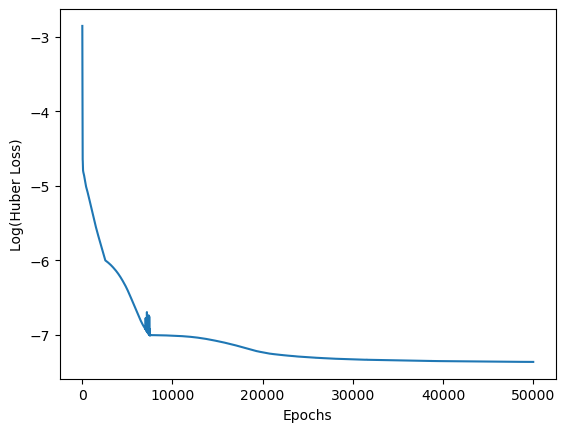

In [54]:
import matplotlib.pyplot as plt

plt.plot(losstracker.keys(),losstracker.values())
plt.xlabel('Epochs')
plt.ylabel('Log(Huber Loss)')
plt.savefig('test-loss-epochs-3outputnn1.png')
plt.show()

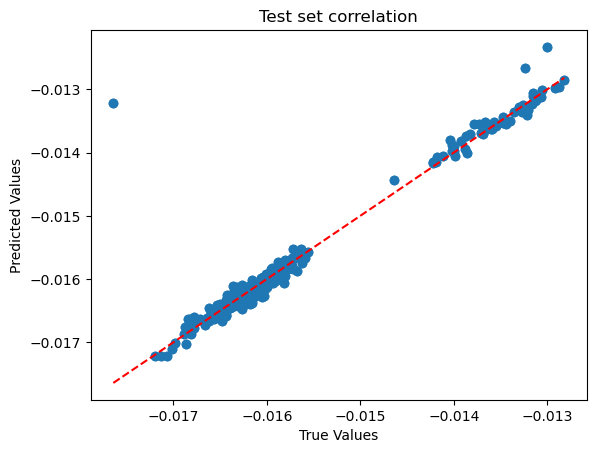

In [55]:
#nn1.save('alkeneselfnn1_model.keras')
#nn2.save('alkeneselfnn2_model.keras')
predictions=predict(testfeats,testaddfeats)

plt.scatter(testselflabels,predictions)
plt.plot((min(testselflabels),max(testselflabels)),(min(testselflabels),max(testselflabels)),c='red',linestyle='--')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Test set correlation')
plt.savefig('testselfset.png')
plt.show()

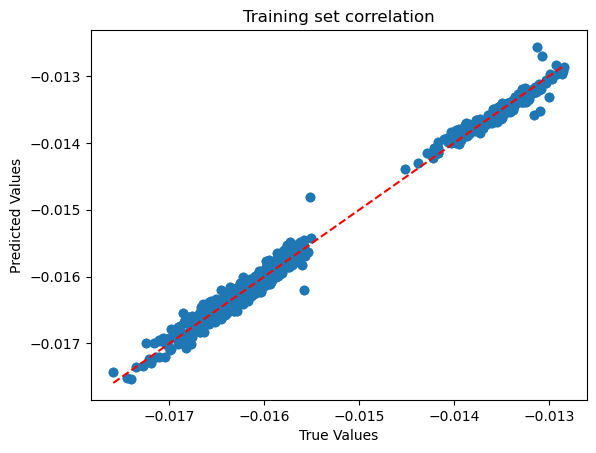

In [56]:
#nn1.save('alkeneselfnn1_model.keras')
#nn2.save('alkeneselfnn2_model.keras')
predictions=predict(trainselffeats,trainselfaddfeats)

plt.scatter(trainselflabels,predictions)
plt.plot((min(trainselflabels),max(trainselflabels)),(min(trainselflabels),max(trainselflabels)),c='red',linestyle='--')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Training set correlation')
plt.savefig('trainselfset.png')
plt.show()

In [53]:
nn1.save('alkane-scaled-self-nn1_model.keras')
nn2.save('alkane-scaled-self-nn2_model.keras')

In [6]:
gpu_options = tf.GPUOptions(allow_growth=True)
session = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))

AttributeError: module 'tensorflow' has no attribute 'GPUOptions'

In [18]:
split=int(0.8*len(noselflabellist))

trainorbital1density=np.stack(orbi1denslist[:split])
trainorbital1other=np.stack(orbi1otherlist[:split])
trainorbital2density=np.stack(orbi2denslist[:split])
trainorbital2other=np.stack(orbi2otherlist[:split])
traindistance=np.stack(distancelist[:split])
trainlabels=np.stack(noselflabellist[:split])

testorbital1density=np.stack(orbi1denslist[split:])
testorbital1other=np.stack(orbi1otherlist[split:])
testorbital2density=np.stack(orbi2denslist[split:])
testorbital2other=np.stack(orbi2otherlist[split:])
testdistance=np.stack(distancelist[split:])
testlabels=np.stack(noselflabellist[split:])

# Saving training data
np.save('data/trainorbital1density.npy', trainorbital1density)
np.save('data/trainorbital1other.npy', trainorbital1other)
np.save('data/trainorbital2density.npy', trainorbital2density)
np.save('data/trainorbital2other.npy', trainorbital2other)
np.save('data/traindistance.npy', traindistance)
np.save('data/trainlabels.npy', trainlabels)

# Saving test data
np.save('data/testorbital1density.npy', testorbital1density)
np.save('data/testorbital1other.npy', testorbital1other)
np.save('data/testorbital2density.npy', testorbital2density)
np.save('data/testorbital2other.npy', testorbital2other)
np.save('data/testdistance.npy', testdistance)
np.save('data/testlabels.npy', testlabels)

In [8]:
import tensorflow as tf
import keras
import numpy as np
import math

# Loading training data
trainorbital1density = np.load('data/trainorbital1density.npy')
trainorbital1other = np.load('data/trainorbital1other.npy')
trainorbital2density = np.load('data/trainorbital2density.npy')
trainorbital2other = np.load('data/trainorbital2other.npy')
traindistance = np.load('data/traindistance.npy')
trainlabels = np.load('data/trainlabels.npy')

# Loading test data
testorbital1density = np.load('data/testorbital1density.npy')
testorbital1other = np.load('data/testorbital1other.npy')
testorbital2density = np.load('data/testorbital2density.npy')
testorbital2other = np.load('data/testorbital2other.npy')
testdistance = np.load('data/testdistance.npy')
testlabels = np.load('data/testlabels.npy')






#intepret density and pass to nn2
class orbitalnn1(tf.keras.Model):
    def __init__(self):
        super(orbitalnn1, self).__init__()
        self.dense1 = tf.keras.layers.Dense(640, activation='softmax')
        self.dense2 = tf.keras.layers.Dense(64)
    
    def call(self, inputs):
        x = self.dense1(inputs)
        return self.dense2(x)

# combines the density with additional information to form a ML compatible orbital object
class orbitalnn2(tf.keras.Model):
    def __init__(self):
        super(orbitalnn2, self).__init__()
        self.dense1 = tf.keras.layers.Dense(320, activation='softmax')
        self.dense2 = tf.keras.layers.Dense(64) 
    
    def call(self, inputs):
        x = self.dense1(inputs)
        return self.dense2(x)

#takes both of the orbital objects and the distances array to then produces a correlation energy estimate
class correlationNN(tf.keras.Model):
    def __init__(self):
        super(correlationNN, self).__init__()
        self.dense1 = tf.keras.layers.Dense(4096, activation='softmax')
        self.dense2 = tf.keras.layers.Dense(1)
        
    
    def call(self, inputs):
        x = self.dense1(inputs)
        return self.dense2(x)

def predict(orbital1density,orbital1other, orbital2density, orbital2other, distances):

    #generate orbital 1
    orbital1nn1=orbinn1(orbital1density)
    orbital1nn2_input=tf.concat([orbital1nn1,orbital1other],axis=1)
    orbital1=orbinn2(orbital1nn2_input)
    
    #generate orbital 2
    orbital2nn1=orbinn1(orbital2density)
    orbital2nn2_input=tf.concat([orbital2nn1,orbital2other],axis=1)
    orbital2=orbinn2(orbital2nn2_input)

    #feedforward to obtain the answer
    correlation_input=tf.concat([orbital1nn1,orbital2nn1,distances],axis=1)
    correlation_energy=corrNN(correlation_input)
    
    
    return correlation_energy 



orbinn1 = orbitalnn1()
orbinn2 = orbitalnn2()
corrNN = correlationNN()

# Optimizers
optimizer = tf.keras.optimizers.Adam()

# Loss function
loss_fn = tf.keras.losses.Huber()

losstracker={}

epochs=5000
batch_size=3024
batches=len(trainlabels)//batch_size

testloss=0
for epoch in range(epochs):

    epoch_loss = 0
    for i in range(batches):
        # Generate batch indices
        start_idx = i * batch_size
        end_idx = start_idx + batch_size
        
        # Select the batch
        orbital1dens_batch = trainorbital1density[start_idx:end_idx]
        orbital1_other_batch = trainorbital1other[start_idx:end_idx]
        orbital2dens_batch = trainorbital2density[start_idx:end_idx]
        orbital2_other_batch = trainorbital2other[start_idx:end_idx]
        dist_batch = traindistance[start_idx:end_idx]
        y_batch = trainlabels[start_idx:end_idx]

        with tf.GradientTape() as tape:
            # Generate orbital 1
            orbital1nn1 = orbinn1(orbital1dens_batch)
            orbital1nn2_input = tf.concat([orbital1nn1, orbital1_other_batch], axis=1)
            orbital1 = orbinn2(orbital1nn2_input)
            
            # Generate orbital 2
            orbital2nn1 = orbinn1(orbital2dens_batch)
            orbital2nn2_input = tf.concat([orbital2nn1, orbital2_other_batch], axis=1)
            orbital2 = orbinn2(orbital2nn2_input)
        
            # Feedforward to obtain the answer
            correlation_input = tf.concat([orbital1, orbital2, dist_batch], axis=1)
            correlation_energy = corrNN(correlation_input)
        
            # Compute the loss for this batch
            loss = loss_fn(y_batch, correlation_energy)

        # Compute gradients and apply them
        gradients = tape.gradient(loss, orbinn1.trainable_variables + orbinn2.trainable_variables + corrNN.trainable_variables)
        optimizer.apply_gradients(zip(gradients, orbinn1.trainable_variables + orbinn2.trainable_variables + corrNN.trainable_variables))

        # Accumulate the batch loss to the epoch loss
        epoch_loss += loss.numpy()
    
    # At the end of each epoch, evaluate the model on the test set and adjust the learning rate
    if (epoch + 1) % 10 == 0:
        predictions = predict(testorbital1density, testorbital1other, testorbital2density, testorbital2other, testdistance)
        testloss = loss_fn(testlabels, predictions)
        losstracker.update({epoch: math.log10(testloss.numpy())})
        
        # Adjust the learning rate based on the test loss
        if testloss > 10**-3:
            optimizer.learning_rate.assign(0.01)
        elif testloss > 10**-4:
            optimizer.learning_rate.assign(0.005)
        elif testloss > 10**-5:
            optimizer.learning_rate.assign(0.001)
        elif testloss > 10**-6:
            optimizer.learning_rate.assign(0.0005)
        elif testloss > 10**-7:
            optimizer.learning_rate.assign(0.0001)
        elif testloss > 10**-8:
            optimizer.learning_rate.assign(0.000001)
    
    # Print the accumulated epoch loss
    print(f'Epoch {epoch + 1}, Loss: {epoch_loss}, Last Test Loss: {testloss}')

Epoch 1, Loss: 1.6607186239525618e-05, Last Test Loss: 0
Epoch 2, Loss: 1.1101380323452759e-05, Last Test Loss: 0
Epoch 3, Loss: 7.639530167580233e-06, Last Test Loss: 0
Epoch 4, Loss: 4.7349431326892955e-06, Last Test Loss: 0
Epoch 5, Loss: 2.823015435637899e-06, Last Test Loss: 0
Epoch 6, Loss: 2.035013906720451e-06, Last Test Loss: 0
Epoch 7, Loss: 1.9987242581009923e-06, Last Test Loss: 0
Epoch 8, Loss: 1.9615361424030198e-06, Last Test Loss: 0
Epoch 9, Loss: 1.947966225657183e-06, Last Test Loss: 0
Epoch 10, Loss: 1.9405640188097095e-06, Last Test Loss: 1.8227326847863878e-07
Epoch 11, Loss: 1.9370480686120572e-06, Last Test Loss: 1.8227326847863878e-07
Epoch 12, Loss: 1.9314471160214453e-06, Last Test Loss: 1.8227326847863878e-07
Epoch 13, Loss: 1.9305789180634747e-06, Last Test Loss: 1.8227326847863878e-07
Epoch 14, Loss: 1.9296456912343274e-06, Last Test Loss: 1.8227326847863878e-07
Epoch 15, Loss: 1.9290804402771755e-06, Last Test Loss: 1.8227326847863878e-07
Epoch 16, Loss: 1

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

plt.plot(losstracker.keys(),losstracker.values())
plt.xlabel('Epochs')
plt.ylabel('Log(Huber Loss)')
plt.savefig('test-loss-epochs-noself-softmax.png')
plt.show()

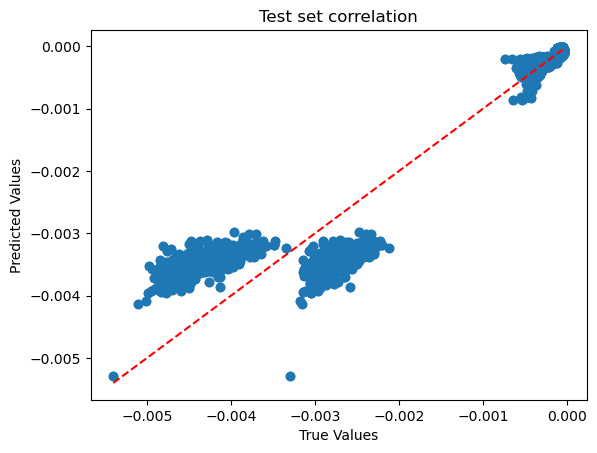

In [5]:
predictions=predict(testorbital1density,testorbital1other,testorbital2density,testorbital2other,testdistance)

plt.scatter(testlabels,predictions)
plt.plot((min(testlabels),max(testlabels)),(min(testlabels),max(testlabels)),c='red',linestyle='--')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Test set correlation')
plt.savefig('testnoselfset-softmax.png')
plt.show()

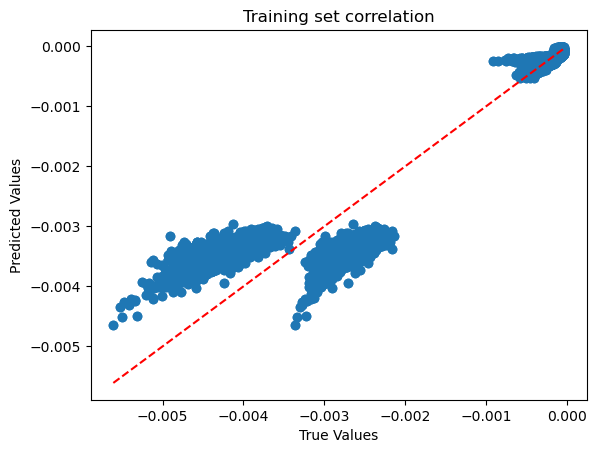

In [6]:
predictions=predict(trainorbital1density,trainorbital1other,trainorbital2density,trainorbital2other,traindistance)
plt.scatter(trainlabels,predictions)
plt.plot((min(trainlabels),max(trainlabels)),(min(trainlabels),max(trainlabels)),c='red',linestyle='--')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Training set correlation')
plt.savefig('trainnoselfset-softmax.png')
plt.show()

In [7]:
orbinn1.save('orbinn1-relu.keras')
orbinn2.save('orbinn2-relu.keras')
corrNN.save('corrNN-relu.keras')

In [25]:
import tensorflow as tf
import keras
import numpy as np
import math

split=int(0.8*len(noselflabellist))

# Loading training data
trainorbital1density = np.load('data/trainorbital1density.npy')
trainorbital1other = np.load('data/trainorbital1other.npy')
trainorbital2density = np.load('data/trainorbital2density.npy')
trainorbital2other = np.load('data/trainorbital2other.npy')
traindistance = np.stack(cdistlist[:split])
traindistance = tf.reshape(traindistance, [-1, 1])
traindistance = tf.cast(traindistance, tf.float32)
trainlabels = np.load('data/trainlabels.npy')

# Loading test data
testorbital1density = np.load('data/testorbital1density.npy')
testorbital1other = np.load('data/testorbital1other.npy')
testorbital2density = np.load('data/testorbital2density.npy')
testorbital2other = np.load('data/testorbital2other.npy')
testdistance = np.stack(cdistlist[split:])
testdistance = tf.reshape(testdistance, [-1, 1])
testdistance = tf.cast(testdistance, tf.float32)
testlabels = np.load('data/testlabels.npy')






#intepret density and pass to nn2
class orbitalnn1(tf.keras.Model):
    def __init__(self):
        super(orbitalnn1, self).__init__()
        self.dense1 = tf.keras.layers.Dense(640, activation='softmax')
        self.dense2 = tf.keras.layers.Dense(64)
    
    def call(self, inputs):
        x = self.dense1(inputs)
        return self.dense2(x)

# combines the density with additional information to form a ML compatible orbital object
class orbitalnn2(tf.keras.Model):
    def __init__(self):
        super(orbitalnn2, self).__init__()
        self.dense1 = tf.keras.layers.Dense(320, activation='softmax')
        self.dense2 = tf.keras.layers.Dense(64) 
    
    def call(self, inputs):
        x = self.dense1(inputs)
        return self.dense2(x)

#takes both of the orbital objects and the distances array to then produces a correlation energy estimate
class correlationNN(tf.keras.Model):
    def __init__(self):
        super(correlationNN, self).__init__()
        self.dense1 = tf.keras.layers.Dense(128, activation='softmax')
        self.dense2 = tf.keras.layers.Dense(1)
        
    
    def call(self, inputs):
        x = self.dense1(inputs)
        return self.dense2(x)

def predict(orbital1density,orbital1other, orbital2density, orbital2other, distances):

    #generate orbital 1
    orbital1nn1=orbinn1(orbital1density)
    orbital1nn2_input=tf.concat([orbital1nn1,orbital1other],axis=1)
    orbital1=orbinn2(orbital1nn2_input)
    
    #generate orbital 2
    orbital2nn1=orbinn1(orbital2density)
    orbital2nn2_input=tf.concat([orbital2nn1,orbital2other],axis=1)
    orbital2=orbinn2(orbital2nn2_input)

    #feedforward to obtain the answer
    correlation_input=tf.concat([orbital1nn1,orbital2nn1,distances],axis=1)
    correlation_energy=corrNN(correlation_input)
    
    
    return correlation_energy 



orbinn1 = orbitalnn1()
orbinn2 = orbitalnn2()
corrNN = correlationNN()

# Optimizers
optimizer = tf.keras.optimizers.Adam()

# Loss function
loss_fn = tf.keras.losses.Huber()

losstracker={}

epochs=25000

testloss=0
for epoch in range(epochs):

    with tf.GradientTape() as tape:
        # Generate orbital 1
        orbital1nn1 = orbinn1(trainorbital1density)
        orbital1nn2_input = tf.concat([orbital1nn1, trainorbital1other], axis=1)
        orbital1 = orbinn2(orbital1nn2_input)
        
        # Generate orbital 2
        orbital2nn1 = orbinn1(trainorbital2density)
        orbital2nn2_input = tf.concat([orbital2nn1, trainorbital2other], axis=1)
        orbital2 = orbinn2(orbital2nn2_input)
    
        # Feedforward to obtain the answer
        correlation_input = tf.concat([orbital1, orbital2, traindistance], axis=1)
        correlation_energy = corrNN(correlation_input)
    
        # Compute the loss for this batch
        loss = loss_fn(trainlabels, correlation_energy)

    # Compute gradients and apply them
    gradients = tape.gradient(loss, orbinn1.trainable_variables + orbinn2.trainable_variables + corrNN.trainable_variables)
    optimizer.apply_gradients(zip(gradients, orbinn1.trainable_variables + orbinn2.trainable_variables + corrNN.trainable_variables))

       
    # At the end of each epoch, evaluate the model on the test set and adjust the learning rate
    if (epoch + 1) % 10 == 0:
        predictions = predict(testorbital1density, testorbital1other, testorbital2density, testorbital2other, testdistance)
        testloss = loss_fn(testlabels, predictions)
        losstracker.update({epoch: math.log10(testloss.numpy())})
        
        # Adjust the learning rate based on the test loss
        if testloss > 10**-3:
            optimizer.learning_rate.assign(0.01)
        elif testloss > 10**-4:
            optimizer.learning_rate.assign(0.005)
        elif testloss > 10**-5:
            optimizer.learning_rate.assign(0.001)
        elif testloss > 10**-6:
            optimizer.learning_rate.assign(0.0005)
        elif testloss > 10**-7:
            optimizer.learning_rate.assign(0.0001)
        elif testloss > 10**-8:
            optimizer.learning_rate.assign(0.000001)
    
    # Print the accumulated epoch loss
    print(f'Epoch {epoch + 1}, Loss: {loss.numpy()}, Last Test Loss: {testloss}')

Epoch 1, Loss: 2.6238729333272204e-05, Last Test Loss: 0
Epoch 2, Loss: 1.3846445654053241e-05, Last Test Loss: 0
Epoch 3, Loss: 5.796521236334229e-06, Last Test Loss: 0
Epoch 4, Loss: 1.9737231014005374e-06, Last Test Loss: 0
Epoch 5, Loss: 1.6584233435423812e-06, Last Test Loss: 0
Epoch 6, Loss: 3.463183702479e-06, Last Test Loss: 0
Epoch 7, Loss: 5.689819317922229e-06, Last Test Loss: 0
Epoch 8, Loss: 7.073904271237552e-06, Last Test Loss: 0
Epoch 9, Loss: 7.186965831351699e-06, Last Test Loss: 0
Epoch 10, Loss: 6.246389602893032e-06, Last Test Loss: 4.304046797187766e-06
Epoch 11, Loss: 4.750819243781734e-06, Last Test Loss: 4.304046797187766e-06
Epoch 12, Loss: 3.927306352125015e-06, Last Test Loss: 4.304046797187766e-06
Epoch 13, Loss: 3.1174977266346104e-06, Last Test Loss: 4.304046797187766e-06
Epoch 14, Loss: 2.4170508368115406e-06, Last Test Loss: 4.304046797187766e-06
Epoch 15, Loss: 1.8888532622440835e-06, Last Test Loss: 4.304046797187766e-06
Epoch 16, Loss: 1.561972680974

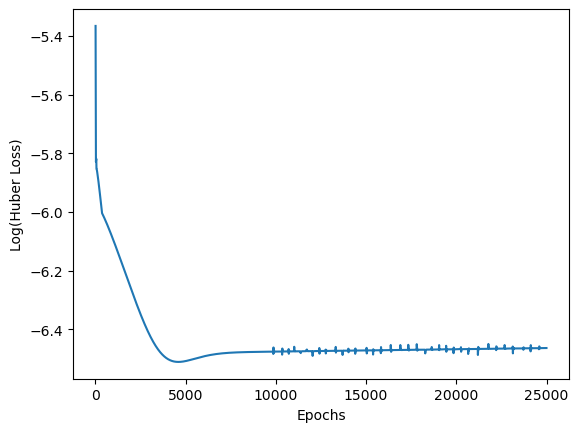

In [26]:
import matplotlib.pyplot as plt

plt.plot(losstracker.keys(),losstracker.values())
plt.xlabel('Epochs')
plt.ylabel('Log(Huber Loss)')
plt.savefig('test-loss-epochs-noself-softmax-centroid-softmax-25k.png')
plt.show()

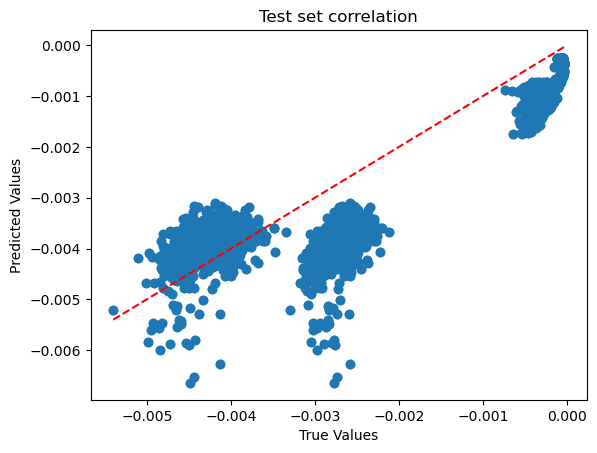

In [27]:
predictions=predict(testorbital1density,testorbital1other,testorbital2density,testorbital2other,testdistance)

plt.scatter(testlabels,predictions)
plt.plot((min(testlabels),max(testlabels)),(min(testlabels),max(testlabels)),c='red',linestyle='--')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Test set correlation')
plt.savefig('testnoselfset-softmax-centroid-softmax-25k.png')
plt.show()

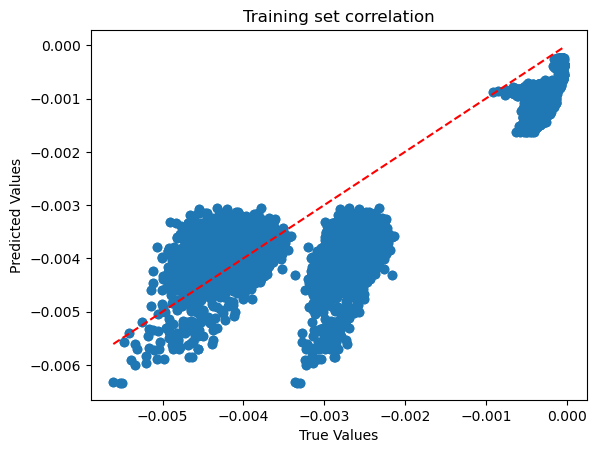

In [28]:
predictions=predict(trainorbital1density,trainorbital1other,trainorbital2density,trainorbital2other,traindistance)
plt.scatter(trainlabels,predictions)
plt.plot((min(trainlabels),max(trainlabels)),(min(trainlabels),max(trainlabels)),c='red',linestyle='--')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Training set correlation')
plt.savefig('trainnoselfset-softmax-centroid-softmax-25k.png')
plt.show()